# SNIC

- Paper: https://openaccess.thecvf.com/content_cvpr_2017/papers/Achanta_Superpixels_and_Polygons_CVPR_2017_paper.pdf
- C implementation: https://github.com/achanta/SNIC

Possible to convert to CUDA? https://cuda-tutorial.readthedocs.io/en/latest/


In [ ]:
!git clone https://github.com/achanta/SNIC.git

Cloning into 'SNIC'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [ ]:
%%bash
cd SNIC/snic_python_interface
python compile_snic_lib.py

generating ./_snic.c
the current directory is '/content/SNIC/snic_python_interface'
running build_ext
building '_snic' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c _snic.c -o ./_snic.o -O3 -march=native -ffast-math
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c snic.c

In [ ]:
import sys
sys.path.append('/content/SNIC/snic_python_interface')

In [ ]:
import os
import subprocess
from PIL import Image
from skimage.io import imread,imshow
import numpy as np
from timeit import default_timer as timer
from _snic.lib import SNIC_main
from cffi import FFI

In [ ]:
def segment(imgname,numsuperpixels,compactness,doRGBtoLAB):
	#--------------------------------------------------------------
	# read image and change image shape from (h,w,c) to (c,h,w)
	#--------------------------------------------------------------
	img = Image.open(imgname)
	# img = imread(imgname)
	img = np.asarray(img)
	print(img.shape)

	dims = img.shape
	h,w,c = dims[0],dims[1],1
	if len(dims) > 1:
		c = dims[2]
		img = img.transpose(2,0,1)
		print(c, "channels")
	
	#--------------------------------------------------------------
	# Reshape image to a single dimensional vector
	#--------------------------------------------------------------
	img = img.reshape(-1).astype(np.double)
	labels = np.zeros((h,w), dtype = np.int32)
	numlabels = np.zeros(1,dtype = np.int32)
	#--------------------------------------------------------------
	# Prepare the pointers to pass to the C function
	#--------------------------------------------------------------
	ffibuilder = FFI()
	pinp = ffibuilder.cast("double*", ffibuilder.from_buffer(img))
	plabels = ffibuilder.cast("int*", ffibuilder.from_buffer(labels.reshape(-1)))
	pnumlabels = ffibuilder.cast("int*", ffibuilder.from_buffer(numlabels))

	
	start = timer()
	SNIC_main(pinp,w,h,c,numsuperpixels,compactness,doRGBtoLAB,plabels,pnumlabels)
	end = timer()

	#--------------------------------------------------------------
	# Collect labels
	#--------------------------------------------------------------
	print("number of superpixels: ", numlabels[0])
	print("time taken in seconds: ", end-start)

	return labels.reshape(h,w),numlabels[0]


	# lib.SNICmain.argtypes = [np.ctypeslib.ndpointer(dtype=POINTER(c_double),ndim=2)]+[c_int]*4 +[c_double,c_bool,ctypes.data_as(POINTER(c_int)),ctypes.data_as(POINTER(c_int))]

def drawBoundaries(imgname,labels,numlabels):

	img = Image.open(imgname)
	# img = imread(imgname)
	img = np.array(img)
	print(img.shape)

	ht,wd = labels.shape

	for y in range(1,ht-1):
		for x in range(1,wd-1):
			if labels[y,x-1] != labels[y,x+1] or labels[y-1,x] != labels[y+1,x]:
				img[y,x,:] = 0

	return img


(425, 640, 3)
3 channels
number of superpixels:  504
time taken in seconds:  0.1609242819999963
(425, 640, 3)


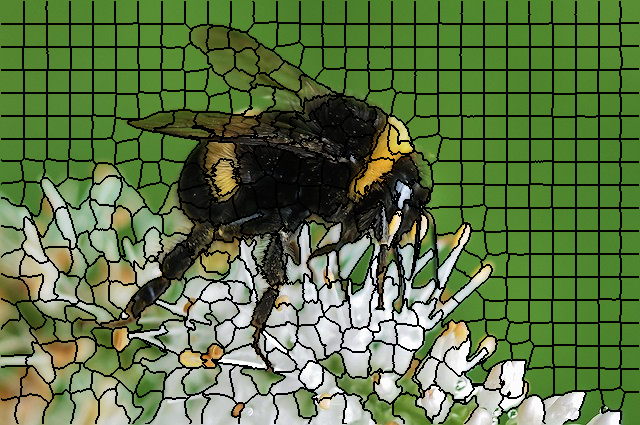

In [ ]:
#--------------------------------------------------------------
# Set parameters and call the C function
#--------------------------------------------------------------
numsuperpixels = 500
compactness = 20.0
doRGBtoLAB = True # only works if it is a three channel image
# imgname = "/Users/achanta/Pictures/classics/lena.png"
imgname = "SNIC/snic_python_interface/bee.png"
labels,numlabels = segment(imgname,numsuperpixels,compactness,doRGBtoLAB)
#--------------------------------------------------------------
# Display segmentation result
#------------------------------------------------------------
segimg = drawBoundaries(imgname,labels,numlabels)
# Image.fromarray(segimg).show()
Image.fromarray(segimg)


In [ ]:
!curl -O https://raw.githubusercontent.com/CSAILVision/ADE20K/main/dataset/ADE20K_2021_17_01/images/ADE/training/urban/street/ADE_train_00016869.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1079k  100 1079k    0     0  1660k      0 --:--:-- --:--:-- --:--:-- 1658k


In [ ]:
numsuperpixels = 500
compactness = 20.0
doRGBtoLAB = True # only works if it is a three channel image
imgname = 'ADE_train_00016869.jpg'
labels,numlabels = segment(imgname,numsuperpixels,compactness,doRGBtoLAB)
segimg = drawBoundaries(imgname,labels,numlabels)
Image.fromarray(segimg)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt

(483, 186, 3)
3 channels
number of superpixels:  198
time taken in seconds:  0.11331458600000133


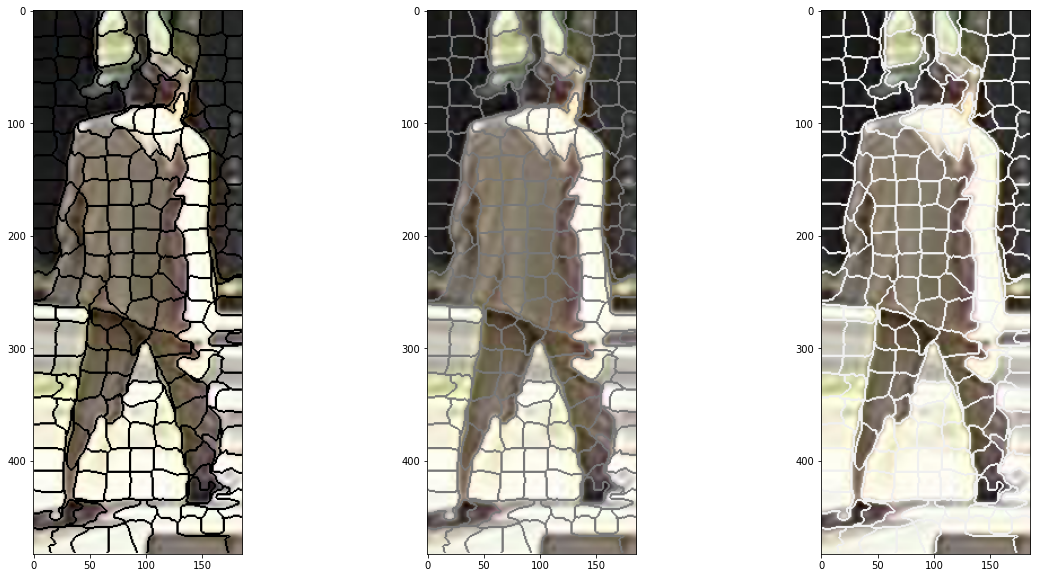

In [ ]:
numsuperpixels = 200
compactness = 20.0
doRGBtoLAB = True # only works if it is a three channel image
imgname = 'ADE_train_00016869.jpg'
#labels,numlabels = segment(imgname,numsuperpixels,compactness,doRGBtoLAB)
#segimg = drawBoundaries(imgname,labels,numlabels)
#Image.fromarray(segimg)
                

img = Image.open(imgname)
img = np.asarray(img)
img = img[845:1006, 554:616, :]

img = Image.fromarray(img)
newsize = 3*np.asarray(img.size)
img = img.resize(newsize)
img = np.asarray(img)

img_box = img.copy()
print(img.shape)

dims = img.shape
h,w,c = dims[0],dims[1],1
if len(dims) > 1:
  c = dims[2]
  img = img.transpose(2,0,1)
  print(c, "channels")

#--------------------------------------------------------------
# Reshape image to a single dimensional vector
#--------------------------------------------------------------
img = img.reshape(-1).astype(np.double)
labels = np.zeros((h,w), dtype = np.int32)
numlabels = np.zeros(1,dtype = np.int32)

#--------------------------------------------------------------
# Prepare the pointers to pass to the C function
#--------------------------------------------------------------
ffibuilder = FFI()
pinp = ffibuilder.cast("double*", ffibuilder.from_buffer(img))
plabels = ffibuilder.cast("int*", ffibuilder.from_buffer(labels.reshape(-1)))
pnumlabels = ffibuilder.cast("int*", ffibuilder.from_buffer(numlabels))


start = timer()
SNIC_main(pinp,w,h,c,numsuperpixels,compactness,doRGBtoLAB,plabels,pnumlabels)
end = timer()

#--------------------------------------------------------------
# Collect labels
#--------------------------------------------------------------
print("number of superpixels: ", numlabels[0])
print("time taken in seconds: ", end-start)

labels, numlabels = labels.reshape(h,w), numlabels[0]

ht, wd = labels.shape

fig, ax = plt.subplots(1, 3, figsize=(20,10))
for color in [0, 120, 240]:
  im = img_box.copy()
  for y in range(1,ht-1):
    for x in range(1,wd-1):
      if labels[y,x-1] != labels[y,x+1] or labels[y-1,x] != labels[y+1,x]:
        im[y,x,:] = color

  ax[color//120].imshow(im)


# OpenCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Fourthbrain Capstone/V2')

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import utils

In [ ]:
img = cv2.imread('ADE_train_00016869.jpg')
img_np = np.array(img)[858-padding:996+padding, 561-padding:616+padding]

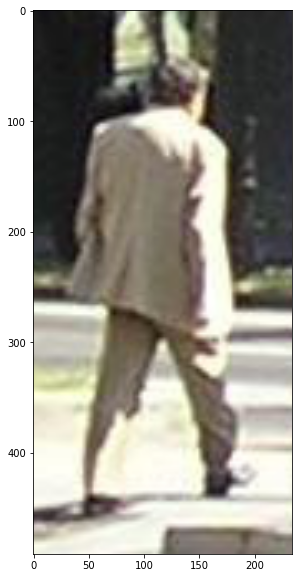

In [ ]:
img = Image.open('/content/ADE_train_00016869.jpg')
img, bbox = utils.get_crop_bbox(np.array(img), bbox=(561, 858, 616, 996), padding=0.2)
img = cv2.resize(img, (0,0), fx=3, fy=3)
plt.figure(figsize=(10,10))
plt.imshow(img)

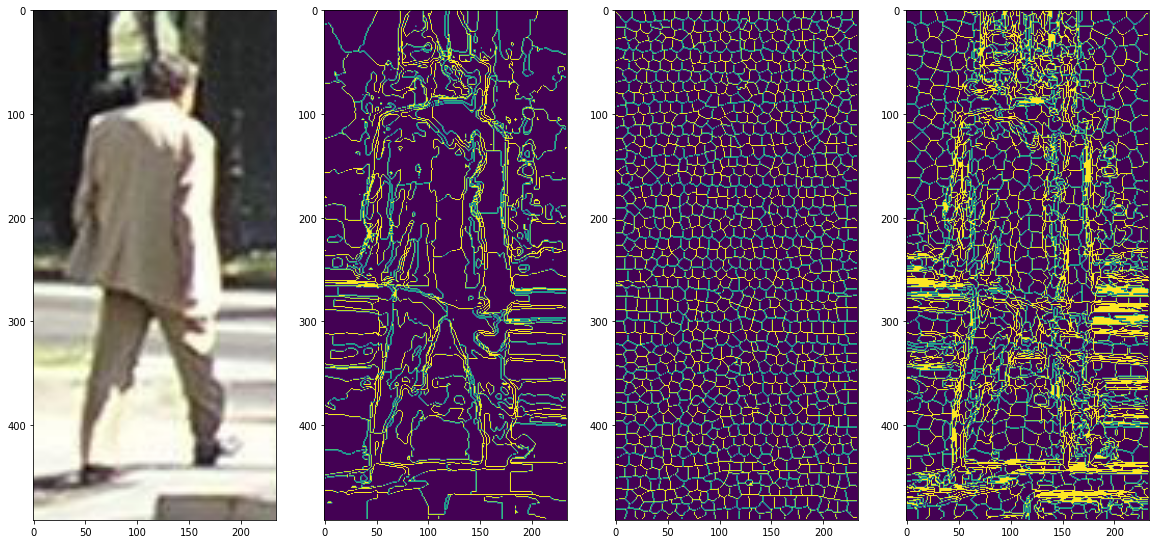

In [ ]:
import cv2.ximgproc as xip
from cv2.ximgproc import createSuperpixelSLIC

img_np = np.array(img)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(img_np)
sp = createSuperpixelSLIC(img_np, algorithm=xip.SLIC, region_size=30)
sp.iterate()
mask_slic = sp.getLabelContourMask()
ax[1].imshow(mask_slic)
sp = createSuperpixelSLIC(img_np, algorithm=xip.SLICO)
sp.iterate()
mask_slico = sp.getLabelContourMask()
ax[2].imshow(mask_slico)
sp = createSuperpixelSLIC(img_np, algorithm=xip.MSLIC)
sp.iterate()
mask_mslic = sp.getLabelContourMask()
ax[3].imshow(mask_mslic)